In [1]:
import os
import re
import json
import scipy
import jsonlines
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr, kendalltau, weightedtau
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
PLMS = ["bert-base-uncased",
        "bert-base-cased",
        "roberta-base",
        "dmis-lab/biobert-base-cased-v1.1",
        "google/electra-base-discriminator",
        "princeton-nlp/unsup-simcse-bert-base-uncased",
        "princeton-nlp/sup-simcse-bert-base-uncased",
        "openai-gpt",
        "facebook/bart-base",
        "allenai/scibert_scivocab_cased",
        "allenai/scibert_scivocab_uncased",
        "distilbert-base-cased",
        "distilbert-base-uncased",
        "nghuyong/ernie-2.0-base-en",
        "distilroberta-base",
        "distilgpt2",
        "distilbert-base-multilingual-cased",
        "albert-base-v2",
        "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        "michiyasunaga/BioLinkBERT-base"][:]

In [3]:
# read all fine-tuning results
DATASETS = ["bioasq9b", "scifact", "mutual"][:]
# DATASETS = ["bioasq9b", "scifact"][:]
tuned_results = {}
for dataset  in DATASETS:
    tuned_results[dataset] = {}
    output_dir = f"output/{dataset}/fine_tuning/"
    for folder in os.listdir(output_dir):
        plm_name = folder.replace(f"_mean", "")
        # print(plm_name)
        tuned_results[dataset][plm_name] = {}
        tuned_results[dataset][plm_name]["best"] = {
            "mrr": 0,
            "p1": 0,
            "r5": 0,
            "r10": 0
        }
        for file in os.listdir(output_dir+folder):
            lr = file.split("_")[-1].replace("lr", "")

            file_path = output_dir+folder+f"/{file}/run.log"
            with open(file_path, "r", encoding="utf-8") as f:
                log = f.read()
            epoch_scores = re.findall("\[Seed: \d+\] - \(Test \).+\n", log)
            # try:
            # assert len(epoch_scores) == 50, file_path
            # except:
                # continue
            max_scores = defaultdict(dict)
            for i in range(len(epoch_scores)):
                seed = re.search("\[Seed: \d+\]", epoch_scores[i]).group()
                seed = re.search("\d+", seed).group()
                max_scores[seed] = max_scores.get(seed, {"mrr":0, "p1":0, "r5":0, "r10":0})
                mrr, p1, r5, r10 = re.findall("\d+\.\d+", epoch_scores[i])
                mrr, p1, r5, r10 = float(mrr), float(p1), float(r5), float(r10)

                for score in ["mrr", "p1", "r5", "r10"]:
                    max_scores[seed][score] = max_scores[seed][score] if eval(score) < max_scores[seed][score] else eval(score)
            for score in ["mrr", "p1", "r5", "r10"]:
                max_scores["overall"][score] = np.mean([max_scores[seed][score] for seed in max_scores.keys() if seed != "overall"])

            # tuned_results[dataset][plm_name][lr] = max_scores
            for score in ["mrr", "p1", "r5", "r10"]:
                if max_scores["overall"][score] > tuned_results[dataset][plm_name]["best"][score]:
                    tuned_results[dataset][plm_name]["best"][score] = max_scores["overall"][score]

In [4]:
for plm in PLMS:
    plm = plm.split("/")[-1]
    line = [plm]
    for dataset in DATASETS:
        for metric in ["mrr", "p1", "r10"]:
            line.append("%2.3f" % (float(tuned_results[dataset][plm]["best"][metric])/100))
    print((' & '.join(line)+ r' \\').replace("0.","."))

bert-base-uncased & .693 & .589 & .784 & .618 & .515 & .799 & .427 & .262 & .743 \\
bert-base-cased & .677 & .572 & .752 & .607 & .507 & .777 & .434 & .270 & .749 \\
roberta-base & .625 & .509 & .735 & .578 & .477 & .758 & .443 & .277 & .765 \\
biobert-base-cased-v1.1 & .739 & .633 & .834 & .672 & .565 & .873 & .399 & .244 & .692 \\
electra-base-discriminator & .624 & .527 & .685 & .385 & .285 & .557 & .345 & .213 & .613 \\
unsup-simcse-bert-base-uncased & .696 & .591 & .785 & .603 & .498 & .795 & .419 & .254 & .741 \\
sup-simcse-bert-base-uncased & .703 & .605 & .785 & .612 & .514 & .802 & .442 & .275 & .758 \\
openai-gpt & .590 & .484 & .671 & .577 & .480 & .753 & .351 & .195 & .664 \\
bart-base & .672 & .563 & .778 & .621 & .523 & .797 & .461 & .285 & .801 \\
scibert_scivocab_cased & .725 & .617 & .824 & .647 & .529 & .866 & .374 & .223 & .672 \\
scibert_scivocab_uncased & .726 & .616 & .833 & .686 & .582 & .886 & .392 & .234 & .704 \\
distilbert-base-cased & .669 & .567 & .748 & .5

In [5]:
def get_rank(pred_list, gt_list):
    pred_rank = np.argsort(-np.array(pred_list))
    rank = np.where(pred_rank==np.argmax(gt_list))[0].item() + 1
    return rank

def avg_time(time_list, unit):
    sum_time = 0.
    for t in time_list:
        if t == '-':
            return t
        sum_time += float(t)
    try:
        return f"%.1f%s"% (sum_time / len(time_list), unit)
    except:
        return "-"

def summarize_results(CANDIDATE_SIZES, tuned_results, tuned_setting, predict_metric):

    all_results = {}
    main_results = {}
    for dataset in DATASETS:
        all_results[dataset] = {}
        main_results[dataset] = {}
        
        for candidate_size in CANDIDATE_SIZES:
            all_results[dataset][candidate_size] = defaultdict(dict)
            
            for metric in MAIN_METRICS:
                all_results[dataset][candidate_size][metric] = defaultdict(dict)
                
                for method in ALL_METHODS:
                    all_results[dataset][candidate_size][metric][method] = defaultdict(dict)
                    
                    method_result_file = f"output/{dataset}/model_selection/{method}.json"
                    with open(method_result_file, 'r') as f:
                        results_dict = json.load(f)
                        
                    rank_list = []
                    spr_list = []
                    pear_list = []
                    wtau_list = []
                    scoring_time_list = []
                    for seed_idx in range(5):
                        model_result_list = []
                        model_time_list = []
                        for plm in PLMS:
                            if method in RANKING_METHODS:
                                model_result_list.append(results_dict[candidate_size][plm]["all_scores"][seed_idx][predict_metric])
                            else:
                                model_result_list.append(results_dict[candidate_size][plm]["all_scores"][seed_idx])
                            model_time_list.append(results_dict[candidate_size][plm]["all_times"][seed_idx])

                        dataset_tuned_results = [tuned_results[dataset][plm.split("/")[-1]][tuned_setting][metric] for plm in PLMS]
                        rank_list += [get_rank(model_result_list, dataset_tuned_results)]
                        spr_list += [spearmanr(model_result_list, dataset_tuned_results).statistic]
                        pear_list += [pearsonr(model_result_list, dataset_tuned_results).statistic]
                        wtau_list += [kendalltau(model_result_list, dataset_tuned_results).statistic]
                        scoring_time_list += [np.sum(model_time_list)]

                    rank = np.mean(rank_list)
                    spr = np.mean(spr_list)
                    pear = np.mean(pear_list)
                    wtau = np.mean(wtau_list)
                    scoring_time = np.mean(scoring_time_list)

                    all_results[dataset][candidate_size][metric][method]['mrr'] = {"mean": np.mean(rank_list),
                                                                                   "std": np.std(rank_list)}
                    all_results[dataset][candidate_size][metric][method]['spr'] = {"mean": np.mean(spr_list),
                                                                                   "std": np.std(spr_list)}
                    all_results[dataset][candidate_size][metric][method]['pear'] = {"mean": np.mean(pear_list),
                                                                                   "std": np.std(pear_list)}
                    all_results[dataset][candidate_size][metric][method]['wtau'] = {"mean": np.mean(wtau_list),
                                                                                   "std": np.std(wtau_list)}
                    all_results[dataset][candidate_size][metric][method]['scoring_time'] = {"mean": np.mean(scoring_time_list),
                                                                                            "std": np.std(scoring_time_list)}

            def avg_score(x, metric):
                return '%.4f'%np.mean(all_results[candidate_size][x][metric])

            main_results[dataset][candidate_size] = defaultdict(dict)

            for metric in MAIN_METRICS:
                main_results[dataset][candidate_size][metric]["mean"] = pd.DataFrame({
                    "Methods": ALL_METHODS,
                    "MRR": [all_results[dataset][candidate_size][metric][m]['mrr']["mean"] for m in ALL_METHODS],
                    "Pearson": [all_results[dataset][candidate_size][metric][m]['pear']["mean"] for m in ALL_METHODS],
                    "Sprearman": [all_results[dataset][candidate_size][metric][m]['spr']["mean"] for m in ALL_METHODS],
                    "Kendall": [all_results[dataset][candidate_size][metric][m]['wtau']["mean"] for m in ALL_METHODS],
                    "Scoring Time": [all_results[dataset][candidate_size][metric][m]['scoring_time']["mean"] for m in ALL_METHODS],
                })
                
                main_results[dataset][candidate_size][metric]["std"] = pd.DataFrame({
                    "Methods": ALL_METHODS,
                    "MRR": [all_results[dataset][candidate_size][metric][m]['mrr']["std"] for m in ALL_METHODS],
                    "Pearson": [all_results[dataset][candidate_size][metric][m]['pear']["std"] for m in ALL_METHODS],
                    "Sprearman": [all_results[dataset][candidate_size][metric][m]['spr']["std"] for m in ALL_METHODS],
                    "Kendall": [all_results[dataset][candidate_size][metric][m]['wtau']["std"] for m in ALL_METHODS],
                    "Scoring Time": [all_results[dataset][candidate_size][metric][m]['scoring_time']["std"] for m in ALL_METHODS],
                })
            
    return all_results, main_results

In [6]:
# DATASETS = ["bioasq9b", "scifact", "mutual"][:]
DATASETS = ["bioasq9b", "scifact"][:]
CANDIDATE_SIZES = ["2", "3", "4", "5", "6", "7", "8", "9", "10"][:]
ALL_METHODS = [
    "Logistic",
    "GBC",
    "TransRate",
    "HScore",
    # "HScoreR",
    "SFDA", 
    "PACTran-0.1-10",
    # "PACTran-0.1-1", 
    # "PACTran-1-100", 
    # "PACTran-1-10", 
    # "PACTran-10-1000", 
    # "PACTran-10-100",
    "LogME",
    "ZeroShotProxy",
    "ZeroShotProxy-whitening",
    "RLogME",
    "RLogME-whitening",
    "Rreg-lir",
    "Rreg-lir-whitening",
    "Rreg-lor",
    "Rreg-lor-whitening",
    # "Rreg",
]
RANKING_METHODS = ["ZeroShotProxy", "ZeroShotProxy-whitening", "RLogME", "RLogME-whitening", \
                   "Rreg-lir","Rreg-lir-whitening","Rreg-lor","Rreg-lor-whitening",
                   # "Rreg",
                  ]

# ALL_METHODS += RANKING_METHODS


MAIN_METRICS = ["mrr", "p1", "r5", "r10"]
tuned_setting = "best"
all_results, main_results = summarize_results(CANDIDATE_SIZES, tuned_results, tuned_setting, "mrr")

In [7]:
main_results['bioasq9b']["7"]["mrr"]["mean"]

,Methods,MRR,Pearson,Sprearman,Kendall,Scoring Time
0,Logistic,15.8,-0.079813,-0.199090,-0.150278,83.554418
1,GBC,1.0,0.573025,0.754887,0.578947,20.350407
2,TransRate,19.0,-0.495724,-0.339850,-0.200000,37.625658
3,HScore,1.0,0.562734,0.825564,0.673684,36.296329
4,SFDA,3.0,0.272623,0.478195,0.326316,370.280463
5,PACTran-0.1-10,1.0,0.567763,0.822556,0.652632,998.040903
6,LogME,1.0,0.689394,0.903759,0.747368,30.122011
7,ZeroShotProxy,4.0,0.608723,0.553383,0.378947,1.217998
8,ZeroShotProxy-whitening,1.0,0.491973,0.719067,0.564646,1.093514
9,RLogME,1.0,0.574479,0.784962,0.652632,34.486197


In [8]:
main_results['bioasq9b']["10"]["r5"]["mean"]

,Methods,MRR,Pearson,Sprearman,Kendall,Scoring Time
0,Logistic,16.4,-0.116237,-0.196303,-0.136094,109.357874
1,GBC,1.0,0.514907,0.691729,0.526316,29.407568
2,TransRate,18.0,-0.425827,-0.311278,-0.210526,50.396709
3,HScore,1.0,0.532831,0.756391,0.642105,42.239313
4,SFDA,3.0,0.188487,0.437594,0.273684,505.038081
5,PACTran-0.1-10,1.0,0.559822,0.793985,0.663158,1382.550733
6,LogME,1.0,0.614278,0.834586,0.694737,15.190210
7,ZeroShotProxy,4.0,0.543937,0.458647,0.305263,1.252151
8,ZeroShotProxy-whitening,1.0,0.490096,0.718315,0.585754,1.284030
9,RLogME,1.0,0.511652,0.742384,0.649079,17.381339


In [ ]:
ALL_METHODS = [
    "RLogME",
    "RLogME-whitening",
    "Rreg-lir",
    "Rreg-lir-whitening",
    "Rreg-lor",
    "Rreg-lor-whitening",
]

tuned_setting = "best"
_, RLogME_p1_results = summarize_results(CANDIDATE_SIZES, tuned_results, tuned_setting, "p1")
_, RLogME_r10_results = summarize_results(CANDIDATE_SIZES, tuned_results, tuned_setting, "r10")

In [15]:
pd.DataFrame(main_results["bioasq9b"]["5"]["mrr"]["std"])

,Methods,MRR,Pearson,Sprearman,Kendall,Scoring Time
0,Logistic,0.000000,0.006773,0.023864,0.017118,1.566155
1,GBC,0.000000,0.000280,0.016168,0.012276,0.058258
2,TransRate,0.000000,0.004354,0.004793,0.007877,1.162130
3,HScore,0.000000,0.001953,0.007644,0.006657,1.493659
4,SFDA,0.000000,0.003078,0.000000,0.000000,6.856697
5,PACTran-0.1-10,0.000000,0.001746,0.009680,0.010314,23.133536
6,LogME,0.000000,0.002618,0.003967,0.004211,0.908847
7,ZeroShotProxy,0.000000,0.002303,0.009023,0.008421,0.018677
8,ZeroShotProxy-whitening,0.000000,0.001273,0.016044,0.012276,0.048586
9,RLogME,0.000000,0.004131,0.017214,0.017133,4.034011


In [9]:
# find the best scores
def extract_best_results(main_results):
    
    best_results = dict()
    for dataset in DATASETS:
        best_results[dataset] = dict()
        for metric in MAIN_METRICS:
            best_mrrs = []
            best_pears = []
            best_rhos = []
            best_taus = []
            # best_stimes = []
            best_rho_css = []
            best_tau_css = []
            for m in ALL_METHODS:
                mrr = 0
                pear = -1
                rho = -1
                tau = -1
                best_rho_cs = 2
                best_tau_cs = 2
                
                for cs in CANDIDATE_SIZES:
                    if pear < float(main_results[dataset][cs][metric]["mean"].query(f'Methods=="{m}"')['Pearson'].item()):
                        pear = float(main_results[dataset][cs][metric]["mean"].query(f'Methods=="{m}"')['Pearson'].item())
                        
                    if rho < float(main_results[dataset][cs][metric]["mean"].query(f'Methods=="{m}"')['Sprearman'].item()):
                        # mrr = float(main_results[dataset][cs][metric].query(f'Methods=="{m}"')['MRR'].item())
                        rho = float(main_results[dataset][cs][metric]["mean"].query(f'Methods=="{m}"')['Sprearman'].item())
                        # stime = main_results[dataset][cs][metric].query(f'Methods=="{m}"')['Scoring Time'].item()
                        best_rho_cs = cs
                    if tau < float(main_results[dataset][cs][metric]["mean"].query(f'Methods=="{m}"')['Kendall'].item()):
                        # mrr = float(main_results[dataset][cs][metric].query(f'Methods=="{m}"')['MRR'].item())
                        tau = float(main_results[dataset][cs][metric]["mean"].query(f'Methods=="{m}"')['Kendall'].item())
                        # stime = main_results[dataset][cs][metric].query(f'Methods=="{m}"')['Scoring Time'].item()
                        best_tau_cs = cs
                # best_mrrs += ["%.4f"%mrr]
                best_pears += ["%.4f"%pear]
                best_rhos += ["%.4f"%rho]
                best_taus += ["%.4f"%tau]
                # best_stimes += [stime]
                best_rho_css += [str(best_rho_cs)]
                best_tau_css += [str(best_tau_cs)]
            
            best_results[dataset][metric] = pd.DataFrame({
                "Methods": ALL_METHODS,
                # "MRR": best_mrrs,
                # "Pearson": best_pears,
                "Sprearman": best_rhos,
                "Kendall": best_taus,
                # "Scoring Time": best_stimes,
                "Best Rho Candidate Size": best_rho_css,
                "Best Tau Candidate Size": best_tau_css
            })
    
    return best_results

best_results = extract_best_results(main_results)

In [10]:
pd.DataFrame(best_results['bioasq9b']['mrr'])

,Methods,Sprearman,Kendall,Best Rho Candidate Size,Best Tau Candidate Size
0,Logistic,-0.0930,-0.0614,9,9
1,GBC,0.7549,0.5789,7,7
2,TransRate,0.0707,0.0316,2,2
3,HScore,0.8256,0.6737,7,7
4,SFDA,0.5068,0.4000,5,5
5,PACTran-0.1-10,0.8226,0.6611,7,8
6,LogME,0.9323,0.8000,6,6
7,ZeroShotProxy,0.5955,0.4105,4,5
8,ZeroShotProxy-whitening,0.7414,0.6105,9,9
9,RLogME,0.8582,0.7018,6,6


In [11]:
pd.DataFrame(best_results['bioasq9b']['p1'])

,Methods,Sprearman,Kendall,Best Rho Candidate Size,Best Tau Candidate Size
0,Logistic,-0.0537,-0.0509,3,9
1,GBC,0.7865,0.6105,6,6
2,TransRate,0.1293,0.0737,2,2
3,HScore,0.7759,0.5684,7,7
4,SFDA,0.4962,0.4000,5,5
5,PACTran-0.1-10,0.7681,0.5579,8,10
6,LogME,0.9128,0.7368,6,6
7,ZeroShotProxy,0.6376,0.4316,5,5
8,ZeroShotProxy-whitening,0.6947,0.5474,9,9
9,RLogME,0.8251,0.6211,6,8


In [12]:
pd.DataFrame(best_results['bioasq9b']['r5'])

,Methods,Sprearman,Kendall,Best Rho Candidate Size,Best Tau Candidate Size
0,Logistic,-0.0951,-0.0655,9,9
1,GBC,0.7248,0.5579,8,7
2,TransRate,0.0466,0.0105,2,2
3,HScore,0.8211,0.6947,7,7
4,SFDA,0.4827,0.3579,5,4
5,PACTran-0.1-10,0.8271,0.6947,7,7
6,LogME,0.9188,0.7789,6,6
7,ZeroShotProxy,0.5624,0.4105,4,5
8,ZeroShotProxy-whitening,0.7248,0.6105,9,9
9,RLogME,0.8432,0.7018,6,6


In [13]:
pd.DataFrame(best_results['scifact']['mrr'])

,Methods,Sprearman,Kendall,Best Rho Candidate Size,Best Tau Candidate Size
0,Logistic,0.1107,0.0978,3,3
1,GBC,0.6090,0.4737,6,6
2,TransRate,0.0767,0.0421,6,6
3,HScore,0.8195,0.6526,6,6
4,SFDA,0.7459,0.5368,9,10
5,PACTran-0.1-10,0.8000,0.6526,6,6
6,LogME,0.8541,0.7158,9,10
7,ZeroShotProxy,0.6632,0.5158,5,5
8,ZeroShotProxy-whitening,0.8722,0.7474,9,9
9,RLogME,0.7985,0.6632,8,7


In [14]:
pd.DataFrame(best_results['scifact']['p1'])

,Methods,Sprearman,Kendall,Best Rho Candidate Size,Best Tau Candidate Size
0,Logistic,0.1054,0.0914,3,3
1,GBC,0.6015,0.4632,6,6
2,TransRate,0.0677,0.0316,6,6
3,HScore,0.8075,0.6421,6,6
4,SFDA,0.7398,0.5263,9,10
5,PACTran-0.1-10,0.7880,0.6421,6,6
6,LogME,0.8617,0.7263,9,10
7,ZeroShotProxy,0.6722,0.5263,5,5
8,ZeroShotProxy-whitening,0.8737,0.7579,9,9
9,RLogME,0.8105,0.6737,8,7


In [15]:
pd.DataFrame(best_results['scifact']['r5'])

,Methods,Sprearman,Kendall,Best Rho Candidate Size,Best Tau Candidate Size
0,Logistic,0.0845,0.0744,3,3
1,GBC,0.6361,0.4947,6,6
2,TransRate,0.1068,0.0632,6,6
3,HScore,0.8226,0.6737,5,5
4,SFDA,0.7353,0.5158,9,10
5,PACTran-0.1-10,0.8030,0.6589,5,5
6,LogME,0.8857,0.7474,9,9
7,ZeroShotProxy,0.6932,0.5368,5,5
8,ZeroShotProxy-whitening,0.8722,0.7263,9,9
9,RLogME,0.8150,0.6842,8,7


In [13]:
METHOD_SHOW_NAME = {
   "Logistic": "LinearProxy",
   "GBC": "GBC",
   "TransRate": "TransRate",
   "HScore": "HScore",
   "HScoreR": "HScoreR",
   "SFDA": "SFDA", 
   "PACTran-0.1-10": "PACTran",
   "LogME": "LogME",
    "Rreg-whitening": "Rreg",
   "RLogME-whitening": "PRaISE",
   "RLogME": "\quad \quad w/o BP",
   "ZeroShotProxy-whitening": "\quad \quad w/o IT",
   "ZeroShotProxy": "ZeroShotProxy",
    "Rreg-whitening": "Rreg-whitening",
    "Rreg": "Rreg",
}

In [14]:
df = best_results
for i in range(len(ALL_METHODS)):
    # print(' & '.join([METHOD_SHOW_NAME[list(df.iloc[i])[0]]] +  list(df.iloc[i])[1:])+ r' \\')
    # print(' & '.join([METHOD_SHOW_NAME[list(df.iloc[i])[0]]] +  [t+'s' for t in list(df.iloc[i])[1:]])+ r' \\')
    
    line = [METHOD_SHOW_NAME[list(df[DATASETS[0]]["mrr"].iloc[i])[0]]]
    for dataset in DATASETS:
        line.extend([list(df[dataset][m].iloc[i])[2] for m in ["mrr", "p1", "r10"]])
    if line[0] == "PRaISE":
        print("\hline")
    print((' & '.join(line)+ r' \\').replace("0.", "."))

\hline
PRaISE & .6105 & .5541 & .6105 & .6842 & .6737 & .6526 \\


In [15]:
df = extract_best_results(RLogME_r10_results)
for i in range(len(ALL_METHODS)):
    # print(' & '.join([METHOD_SHOW_NAME[list(df.iloc[i])[0]]] +  list(df.iloc[i])[1:])+ r' \\')
    # print(' & '.join([METHOD_SHOW_NAME[list(df.iloc[i])[0]]] +  [t+'s' for t in list(df.iloc[i])[1:]])+ r' \\')
    
    line = [METHOD_SHOW_NAME[list(df[DATASETS[0]]["r10"].iloc[i])[0]]]
    for dataset in DATASETS:
        line.extend([list(df[dataset][m].iloc[i])[2] for m in ["mrr", "p1", "r10"]])
    if line[0] == "PRaISE":
        print("\hline")
    print((' & '.join(line)+ r' \\').replace("0.", "."))

\hline
PRaISE & .6526 & .5684 & .6526 & .5783 & .5677 & .5995 \\


In [16]:
RLogME_p1_results

{'bioasq9b': {'2': defaultdict(dict,
              {'mrr': {'mean':             Methods  MRR   Pearson  Sprearman   Kendall  Scoring Time
                0  RLogME-whitening  2.0  0.361353   0.641595  0.490767     22.422536,
                'std':             Methods  MRR  Pearson  Sprearman       Kendall  Scoring Time
                0  RLogME-whitening  0.0      0.0        0.0  5.551115e-17      1.247019},
               'p1': {'mean':             Methods  MRR   Pearson  Sprearman   Kendall  Scoring Time
                0  RLogME-whitening  2.0  0.352318   0.591952  0.406334     22.422536,
                'std':             Methods  MRR  Pearson  Sprearman       Kendall  Scoring Time
                0  RLogME-whitening  0.0      0.0        0.0  5.551115e-17      1.247019},
               'r5': {'mean':             Methods  MRR   Pearson  Sprearman   Kendall  Scoring Time
                0  RLogME-whitening  2.0  0.353349   0.638586  0.490767     22.422536,
                'std':     

In [17]:
ALL_METHODS = [
    "GBC",
    "TransRate",
    "HScore",
    "HScoreR",
    "SFDA", 
    "PACTran-0.1-10",
    "Logistic",
    "LogME",
    "RLogME-whitening",
    "RLogME",
    "ZeroShotProxy-whitening",
    "ZeroShotProxy",
    #  "Rreg-whitening",
]

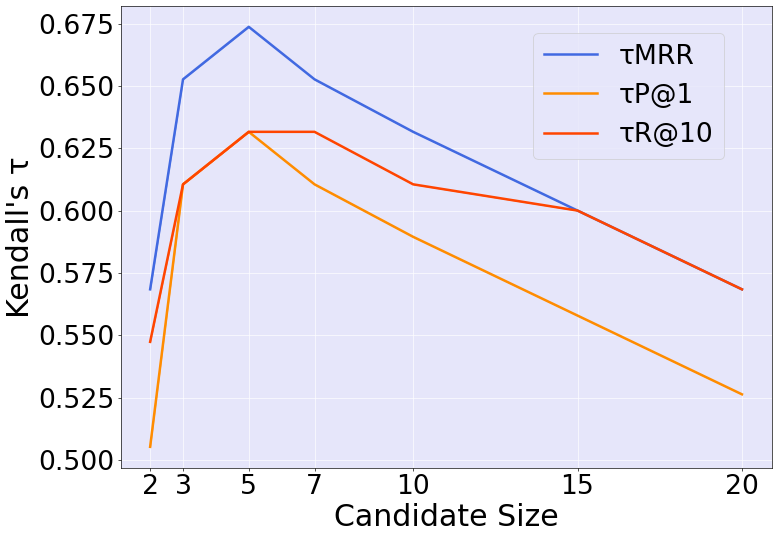

In [37]:
dataset = "bioasq9b"
method = "Rreg-whitening"
show_method = "ARMTran"
css = [2, 3, 5, 7, 10, 15, 20]

Y_tau = {}

METRIC_SHOW_NAME = {
    "mrr": "MRR",
    "p1": "P@1",
    "r10": "R@10"
}
metrics = ["mrr", "p1", "r10"]
show_metrics = [METRIC_SHOW_NAME[m] for m in metrics]

Y_tau[method] = defaultdict(dict)
for metric in metrics:
    Y_tau[method][metric]["mean"] = []
    Y_tau[method][metric]["std"] = []
    for cs in css:
        Y_tau[method][metric]["mean"] += [float(main_results[dataset][str(cs)][metric]["mean"].query(f'Methods=="{method}"')["Kendall"].item())]
        Y_tau[method][metric]["std"] += [float(main_results[dataset][str(cs)][metric]["std"].query(f'Methods=="{method}"')["Kendall"].item())]
    Y_tau[method][metric]["mean"] = np.array(Y_tau[method][metric]["mean"])
    Y_tau[method][metric]["std"] = np.array(Y_tau[method][metric]["std"])
        
line_styles = ["-", "-", "-"]
colors = ["royalblue", "darkorange", "orangered"]

fig = plt.figure(figsize = (14,10), dpi=60)
axes = fig.subplots(nrows=1, ncols=1)

plt.grid(color="white")
ax = fig.axes[0]
ax.set_facecolor("lavender")
for j, metric in enumerate(metrics):
    # show_method+f" ({show_metrics[j]})"
    ax.plot(css, Y_tau[method][metric]["mean"], label=f"τ{show_metrics[j]}", mfc = "white", color=colors[j], linestyle=line_styles[j], linewidth=3)
    ax.fill_between(css, Y_tau[method][metric]["mean"]-Y_tau[method][metric]["std"], Y_tau[method][metric]["mean"]+Y_tau[method][metric]["std"], color=colors[j], alpha=0.3)
ax.set_xlabel('Candidate Size', size=36)
ax.set_ylabel("Kendall's τ", size=36)

tick_size = 32

plt.xticks(css, fontsize=tick_size)
plt.yticks(fontsize=tick_size)


lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'center', fontsize=32, ncol=1, bbox_to_anchor=(0.73, 0.73), facecolor="lavender")
plt.savefig(f'C:\\Users\\Jun Bai\\Desktop\\COLING2024\\figs\\{show_method}_{dataset}.pdf', dpi = 100, bbox_inches = 'tight')
plt.show()

In [19]:
plot_methods = ["kNN-5-corr", "GBC", "HScore", "HScoreR", "MSC-cos", \
                "LFC-cos", "TransRate", "NLEEP", "PARC-corr", "Logistic", "LogME", "SFDA", "PACTran-1-10"]
data_ratios = [0.1, 0.25, 0.5, 0.75, 1.0]
embedding_sizes = [16, 32, 64, 128, 256, 384, 512, 768]
target_model_lm = "deberta-base"
all_results_plot, main_results_plot = summarize_results(data_ratios, embedding_sizes, target_model_lm, plot_methods)

KeyError: 0.1

In [ ]:
plot_methods = ["kNN-5-corr", "PARC-corr", "Logistic", "HScore", "HScoreR", "LogME", "SFDA", "PACTran-1-10"]

show_methods = [METHOD_SHOW_NAME[m] for m in plot_methods]
data_ratios = [0.1, 0.25, 0.5, 0.75, 1.0]

dims = list(main_results_plot[1].keys())
X = list(main_results_plot.keys())
Y_mrr = {}
Y_scc = {}

metric = 'MRR'
for m in plot_methods:
    Y_mrr[m] = []
    for r in data_ratios:
        Y_mrr[m] += [float(main_results_plot[r][int(best_dim_dict[m])]['overall'].query(f'Methods=="{m}"')[metric].item())]

metric = 'Mean SCC'
for m in plot_methods:
    Y_scc[m] = []
    for r in data_ratios:
        Y_scc[m] += [float(main_results_plot[r][int(best_dim_dict[m])]['overall'].query(f'Methods=="{m}"')[metric].item())]


line_styles = ['-.'] * 3 + ['-'] * 5
marker_styles = ['*'] * 3 + ['>'] * 5 

fig = plt.figure(figsize = (14,10), dpi=60)
axes = fig.subplots(nrows=1, ncols=2)

ax = fig.axes[0]
ax.set_facecolor("aliceblue")
for i, m in enumerate(plot_methods):
    ax.plot(["%d"%(float(x)*100)+"%" for x in X], Y_mrr[m], label=show_methods[i], mfc = "white", markeredgewidth=2, linestyle=line_styles[i], linewidth=3, marker=marker_styles[i], markersize=15)
ax.set_xlabel('Data Percentage', size=20)
ax.set_ylabel('MRR', size=20)

tick_size = 18

plt.sca(axes[0])
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid()
    
ax = fig.axes[1]
ax.set_facecolor("ivory")
for i, m in enumerate(plot_methods):
    ax.plot(["%d"%(float(x)*100)+"%" for x in X], Y_scc[m], label=show_methods[i], mfc = "white", markeredgewidth=2, linestyle=line_styles[i], linewidth=3, marker=marker_styles[i], markersize=15)
ax.set_xlabel('Data Percentage', size=20)
ax.set_ylabel(r'$\mu_{\rho}$', size=20)

plt.sca(axes[1])
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper left', fontsize=22, ncol=4, bbox_to_anchor=(0.115, 1.01))
plt.savefig('C:\\Users\\Jun Bai\\Desktop\\EMNLP2023\\data_size_variation.pdf', dpi = 100, bbox_inches = 'tight')
plt.show()